<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 70 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  364 non-null    int64  
 1   Video Duration                      364 non-null    float64
 2   Video Publish Time                  364 non-null    object 
 3   Days Since Publish                  364 non-null    int64  
 4   Day                                 364 non-null    int64  
 5   Month                               364 non-null    int64  
 6   Year                                364 non-null    int64  
 7   Day of Week                         364 non-null    object 
 8   Revenue per 1000 Views (USD)        364 non-null    float64
 9   Monetized Playbacks (Estimate)      364 non-null    float64
 10  Playback-Based CPM (USD)            364 non-null    float64
 11  CPM (USD)                           364 non-n

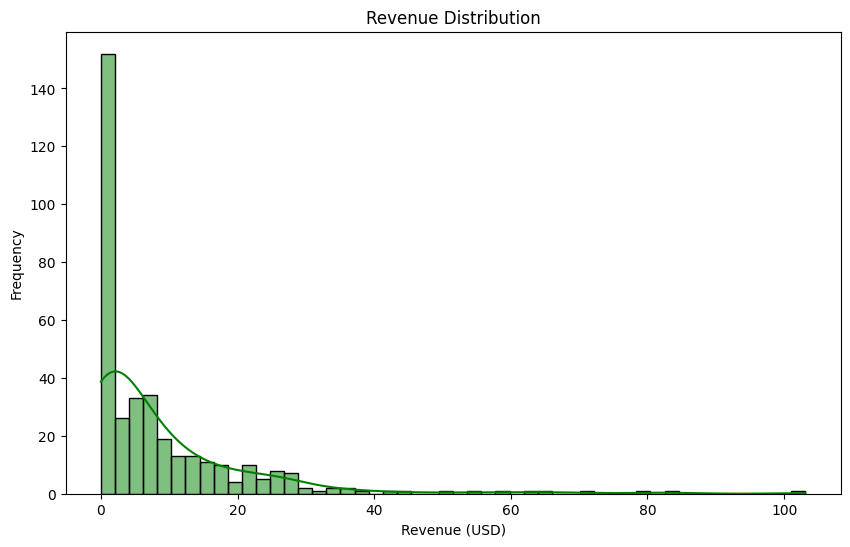

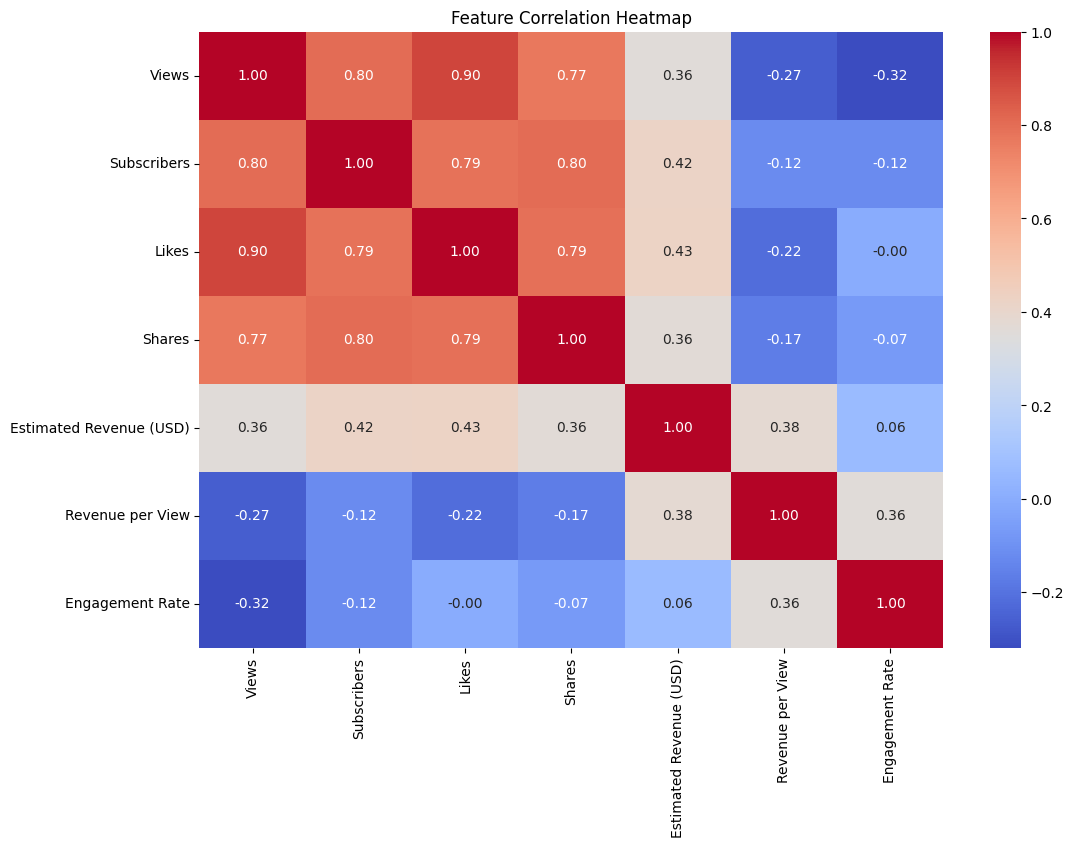

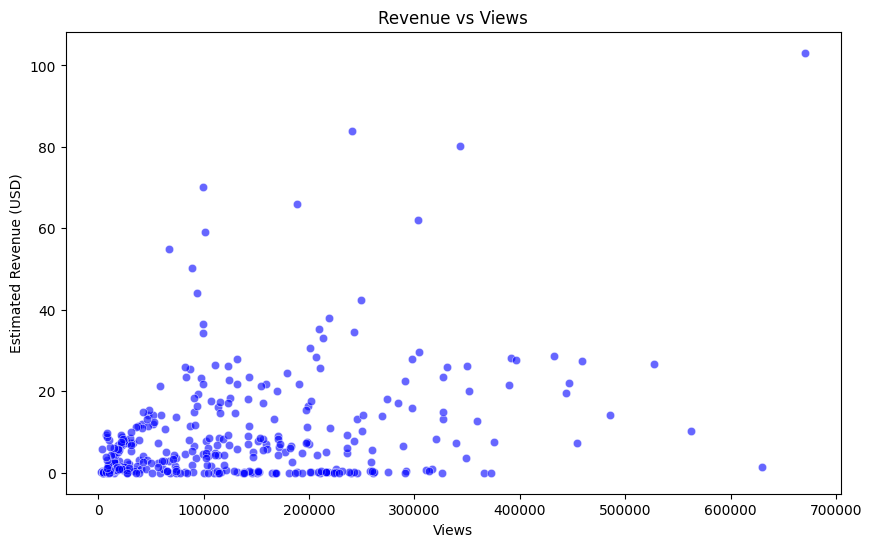

     Estimated Revenue (USD)     Views  Subscribers
228                  103.117  670990.0       3538.0
257                   83.979  241060.0       1125.0
251                   80.265  343319.0       1437.0
289                   70.247   99196.0        350.0
278                   65.978  188324.0       1824.0
260                   62.047  302999.0        866.0
293                   59.058  101025.0        602.0
294                   55.040   67556.0        581.0
290                   50.344   89284.0        995.0
284                   44.228   93487.0        305.0
Mean Squared Error: 90.01
R-squared: -0.03


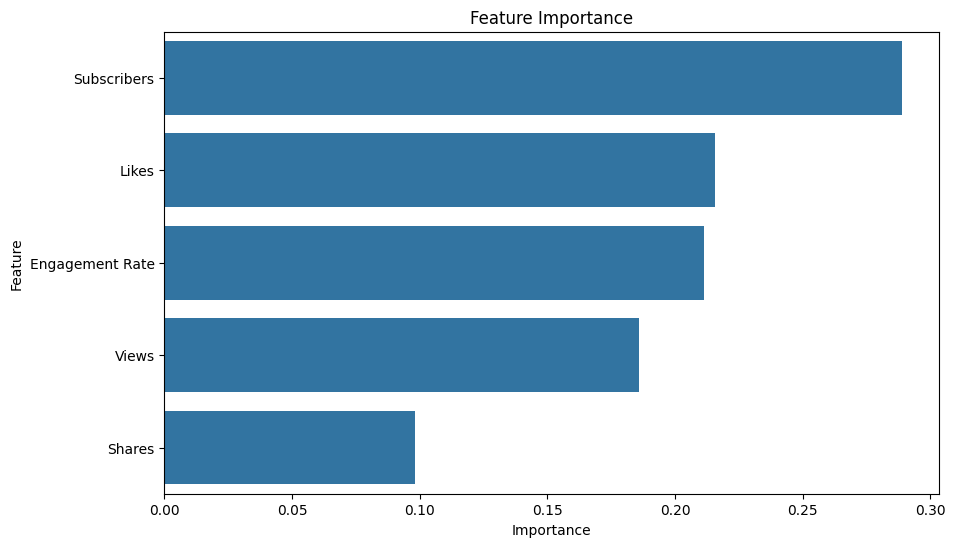

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import re

# Load dataset
file_path = "youtube_channel_real_performance_analytics.csv"
data = pd.read_csv(file_path)

# Basic data exploration
print(data.info())
print(data.isnull().sum())
print("Columns available:", data.columns.tolist())

# Handling missing values by filling with median values
data.fillna(data.median(numeric_only=True), inplace=True)

# Convert 'Video Duration' (ISO 8601 format) to seconds
def parse_duration(duration):
    if isinstance(duration, str):
        match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', duration)
        hours = int(match.group(1)) * 3600 if match.group(1) else 0
        minutes = int(match.group(2)) * 60 if match.group(2) else 0
        seconds = int(match.group(3)) if match.group(3) else 0
        return hours + minutes + seconds
    return 0

data['Video Duration'] = data['Video Duration'].apply(parse_duration)

# Ensure all required columns exist
required_columns = ['Views', 'Subscribers', 'Likes', 'Shares', 'Estimated Revenue (USD)']
available_columns = [col for col in required_columns if col in data.columns]

data = data[available_columns]

# Feature Engineering
data['Revenue per View'] = data['Estimated Revenue (USD)'] / data['Views']
data['Revenue per View'] = data['Revenue per View'].replace([np.inf, -np.inf], 0)  # Handle division by zero

data['Engagement Rate'] = (data['Likes'] + data['Shares']) / data['Views'] * 100
data['Engagement Rate'] = data['Engagement Rate'].replace([np.inf, -np.inf], 0)

# Visualizing distribution of revenue
plt.figure(figsize=(10, 6))
sns.histplot(data['Estimated Revenue (USD)'], bins=50, kde=True, color='green')
plt.title("Revenue Distribution")
plt.xlabel("Revenue (USD)")
plt.ylabel("Frequency")
plt.show()

# Correlation Heatmap (only numeric columns)
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Scatter plot: Views vs Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Views'], y=data['Estimated Revenue (USD)'], alpha=0.6, color='blue')
plt.title("Revenue vs Views")
plt.xlabel("Views")
plt.ylabel("Estimated Revenue (USD)")
plt.show()

# Top 10 revenue-generating videos
top_videos = data.sort_values(by='Estimated Revenue (USD)', ascending=False).head(10)
print(top_videos[['Estimated Revenue (USD)', 'Views', 'Subscribers']])

# Defining features and target
features = ['Views', 'Subscribers', 'Likes', 'Shares', 'Engagement Rate']
target = 'Estimated Revenue (USD)'
X = data[features]
y = data[target]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance")
plt.show()
